# Project Report

## Heart Disease Classification

## Introduction

A heart attack, also known as a myocardial infarction, occurs when blood flow to a part of the heart is blocked, usually by a blood clot. This can cause damage to the heart muscle, which can be life-threatening if not treated promptly. Risk factors for heart attack include smoking, high blood pressure, high cholesterol, obesity, physical inactivity, family history of heart disease, and diabetes. It's important to make lifestyle changes, such as quitting smoking, eating a healthy diet, exercising regularly, and managing any underlying medical conditions, to reduce your risk of heart attack.


Our aim with this project is to build a predictive model that can identify individuals at a high (`target = 1`) or low (`target = 0`) risk of developing heart disease using the KNN model with the predictors `age`, `trestbps`, `chol`, `thalach`, and `oldpeak`.

### About the dataset and its variables

This data set is collected from the Hungarian Institute of Cardiology, Budapest. It was donated in 1988 for analysis and diagnosis of heart disease in patients. This set of data has been used to generate a probability algorithm for the diagnosis of coronary artery disease. Past classifications with this data have acheived an accuracy around 77%.

**age** : Age of the patient

**sex** : Sex of the patient (0 = female ; 1 = male)

**exang**: exercise induced angina (1 = yes; 0 = no)

**ca**: number of major vessels (0-3) colored by flourosopy

**cp** : Chest Pain type 

* Value 0: typical angina

* Value 1: atypical angina

* Value 2: non-anginal pain

* Value 3: asymptomatic

**trtbps** : resting blood pressure (in mm Hg)

**chol** : cholestoral in mg/dl fetched via BMI sensor

**fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false).

**rest_ecg** : resting electrocardiographic results

* Value 0: normal

* Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

* Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

**thalach** : maximum heart rate achieved

**slope** : the slope of the peak exercise ST segment 
* 0: upsloping
* 1: flat 
* 2: downsloping

**oldpeak** :  ST depression induced by exercise relative to rest

**thal** :   1 = normal; 2 = fixed defect; 3 = reversable defect

**target** : 0 = less chance of heart attack ,  1 = more chance of heart attack

**We will only be using age, trestbps, chol, thalach and oldpeak as predictors in our classification.**

In [2]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Data Analysis and Visualization

### Reading the data

In [3]:
heart_data <- read_csv("heart.csv")
heart_data <- heart_data[!(heart_data$thal==0 | heart_data$ca==4),]
heart_data |>
    head(10)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


### Selecting only intrested columns from data set

In [4]:
heart_data_clean <- select(heart_data, age, trestbps, chol, thalach, oldpeak, target) |> mutate(target = as_factor(target))
heart_data_clean |>
    head(10)

age,trestbps,chol,thalach,oldpeak,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,1.0,0
53,140,203,155,3.1,0
70,145,174,125,2.6,0
61,148,203,161,0.0,0
62,138,294,106,1.9,0
58,100,248,122,1.0,1
58,114,318,140,4.4,0
55,160,289,145,0.8,0
46,120,249,144,0.8,0


### Splitting data into training set and testing set

In [5]:
set.seed(2000)
heart_split <- initial_split(heart_data_clean, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

### Creating a recipe that centers and scales all predictor variables

In [6]:
heart_recipe <- recipe(target ~ age + trestbps + chol + thalach + oldpeak , data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

### Performing 5 fold cross validation to find best k value

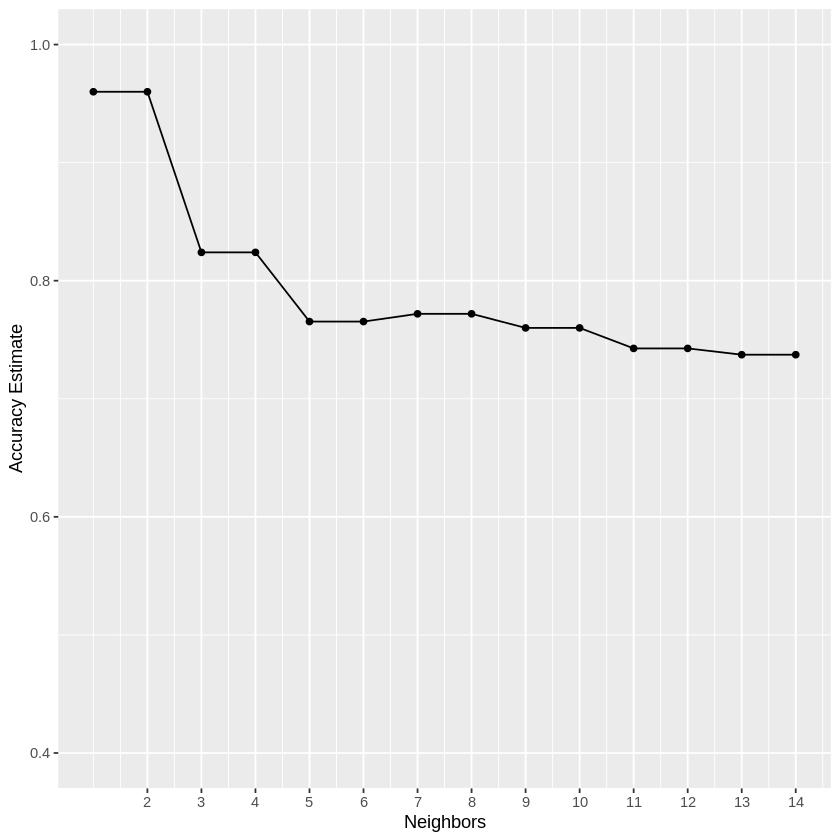

In [21]:
heart_vfold <- vfold_cv(heart_train, v = 5, strata = target)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")
k_vals <- tibble(neighbors = seq(from = 1, to = 14, by = 1))

knn_results <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = heart_vfold , grid = k_vals) |>
       collect_metrics()
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(2, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

### Using best k = 2 for predicting testing data using training data and finding accuracy

In [8]:
heart1_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
       set_engine("kknn") |>
       set_mode("classification")

heart1_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(heart1_spec) |>
       fit(data = heart_train)
heart_predictions <- predict(heart1_fit , heart_test) |>
       bind_cols(heart_test)

heart_metrics <- heart_predictions |>
         metrics(truth = target, estimate = .pred_class)  
head(heart_predictions)
accuracy <- heart_metrics |> filter(.metric == "accuracy")
accuracy

.pred_class,age,trestbps,chol,thalach,oldpeak,target
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,70,145,174,125,2.6,0
0,62,138,294,106,1.9,0
1,58,100,248,122,1.0,1
0,46,120,249,144,0.8,0
1,71,112,149,125,1.6,1
1,34,118,210,192,0.7,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9721116


### Confusion matrix

In [9]:
heart_mat <- heart_predictions |> 
       conf_mat(truth = target, estimate = .pred_class)
heart_mat

          Truth
Prediction   0   1
         0 120   3
         1   4 124

### Visualizations: Plotting graphs of all predictors and coloring them by the target variable

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



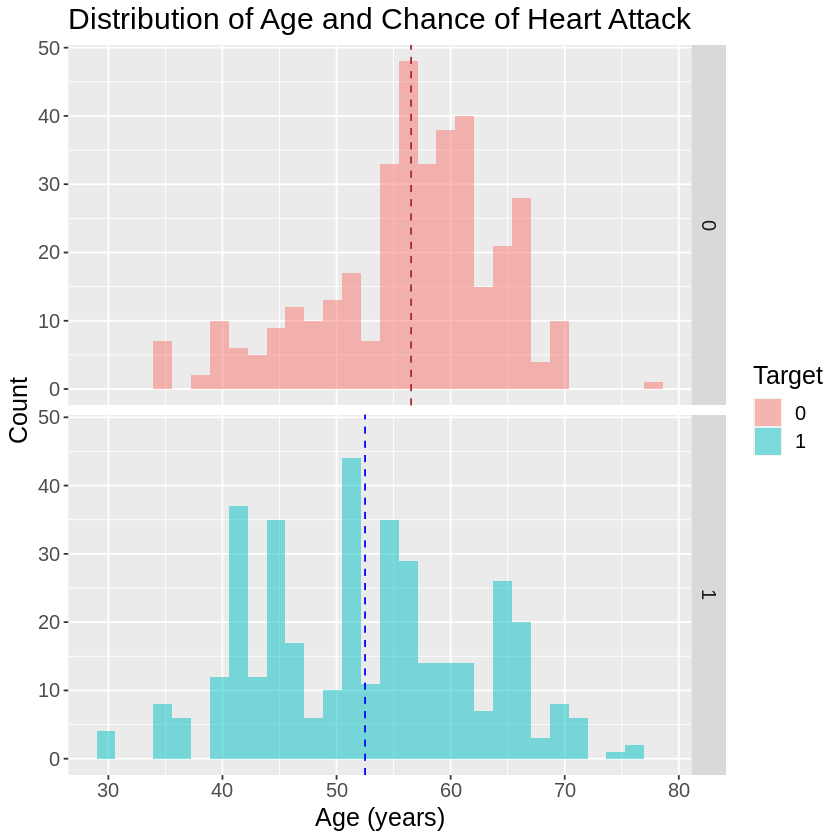

In [10]:
age_plot <- ggplot(heart_train, aes(x = age, fill = target)) + 
    geom_histogram(alpha = 0.5, position = "identity") +
    geom_vline(data = filter(heart_train, target == 0), aes(xintercept = mean(filter(heart_train,  target == 0)$age)),
             color = "brown", linetype = "dashed") +
    geom_vline(data = filter(heart_train, target == 1), aes(xintercept = mean(filter(heart_train,  target == 1)$age)),
             color = "blue", linetype = "dashed") +
    facet_grid(rows = vars(target)) +
    labs(x = "Age (years)", y="Count", fill = "Target") +
    ggtitle("Distribution of Age and Chance of Heart Attack") +
    theme(text = element_text(size = 15))
age_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



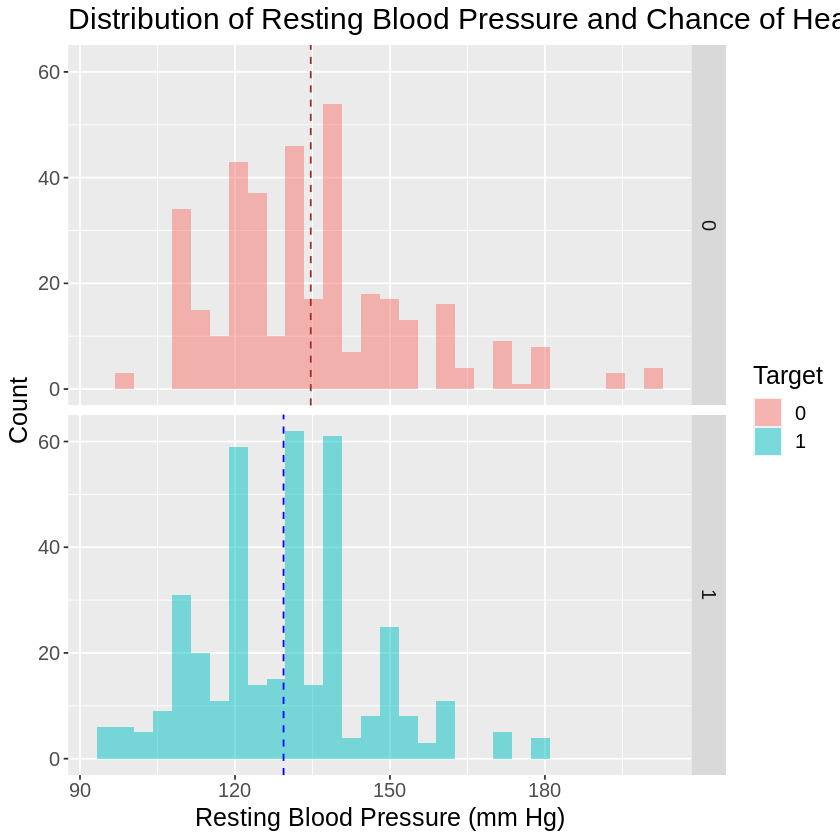

In [11]:
trestbps_plot <- ggplot(heart_train, aes(x = trestbps, fill = target)) + 
    geom_histogram(alpha = 0.5, position = "identity") + 
    geom_vline(data = filter(heart_train, target == 0), aes(xintercept = mean(filter(heart_train,  target == 0)$trestbps)),
             color = "brown", linetype = "dashed") +
    geom_vline(data = filter(heart_train, target == 1), aes(xintercept = mean(filter(heart_train,  target == 1)$trestbps)),
             color = "blue", linetype = "dashed") +
    facet_grid(rows = vars(target)) +
    labs(x = "Resting Blood Pressure (mm Hg)", y="Count", fill = "Target") +
    ggtitle("Distribution of Resting Blood Pressure and Chance of Heart Attack") +
    theme(text = element_text(size = 15))
trestbps_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



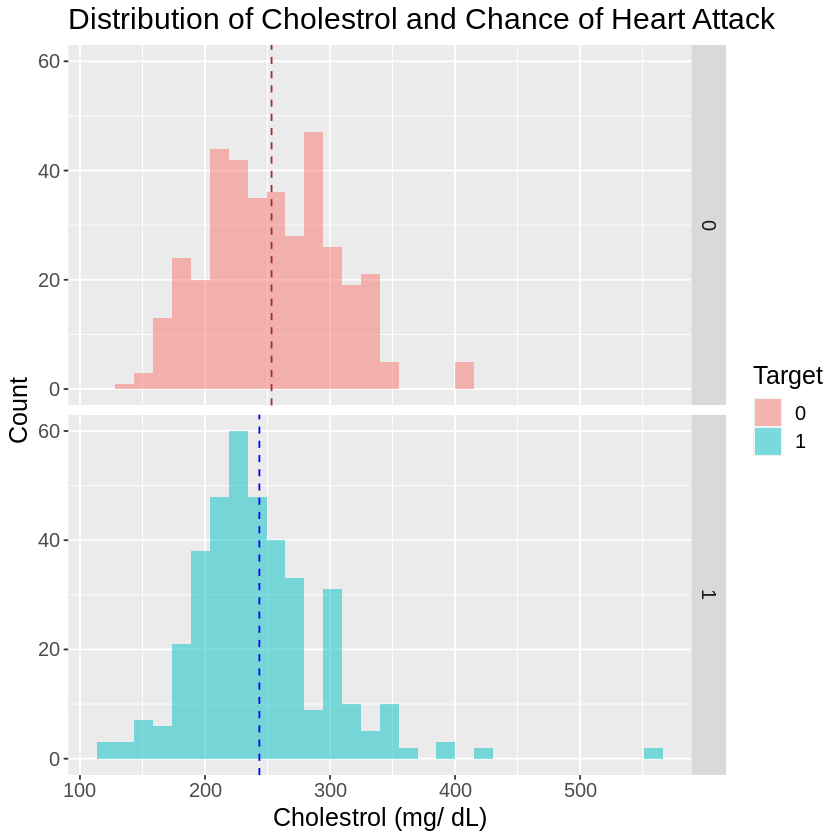

In [12]:
chol_plot <- ggplot(heart_train, aes(x = chol, fill = target)) + 
    geom_histogram(alpha = 0.5, position = "identity") +
    geom_vline(data = filter(heart_train, target == 0), aes(xintercept = mean(filter(heart_train,  target == 0)$chol)),
             color = "brown", linetype = "dashed") +
    geom_vline(data = filter(heart_train, target == 1), aes(xintercept = mean(filter(heart_train,  target == 1)$chol)),
             color = "blue", linetype = "dashed") +
    facet_grid(rows = vars(target)) +
    labs(x = "Cholestrol (mg/ dL)", y="Count", fill = "Target") +
    ggtitle("Distribution of Cholestrol and Chance of Heart Attack") +
    theme(text = element_text(size = 15))
chol_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



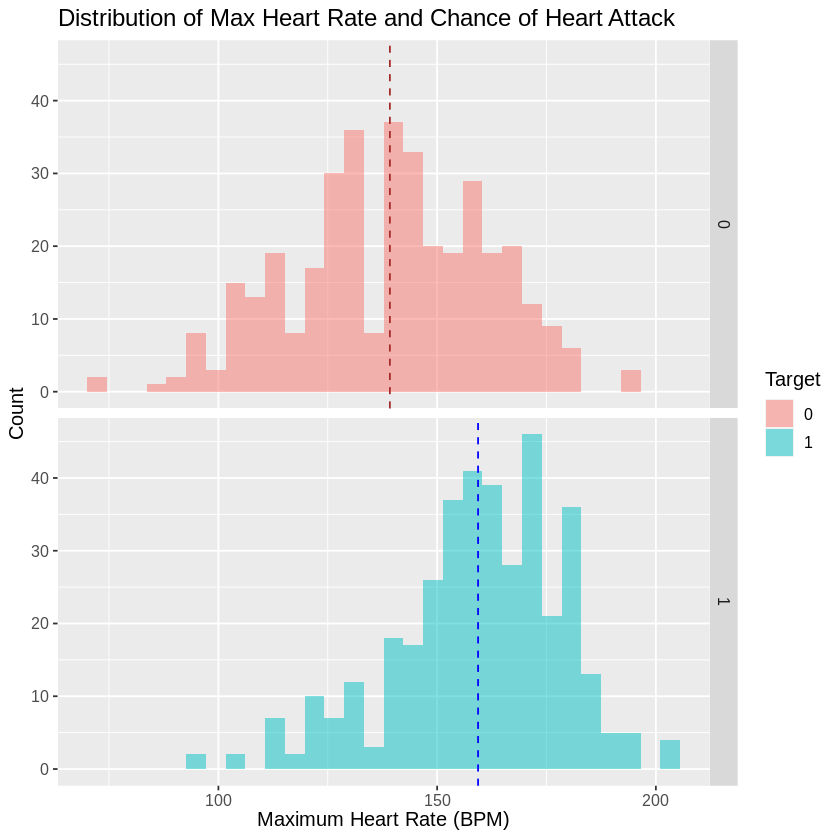

In [13]:
thalach_plot <- ggplot(heart_train, aes(x = thalach, fill = target)) + 
    geom_histogram(alpha = 0.5, position = "identity") +
    geom_vline(data = filter(heart_train, target == 0), aes(xintercept = mean(filter(heart_train,  target == 0)$thalach)),
             color = "brown", linetype = "dashed") +
    geom_vline(data = filter(heart_train, target == 1), aes(xintercept = mean(filter(heart_train,  target == 1)$thalach)),
             color = "blue", linetype = "dashed") +
    facet_grid(rows = vars(target)) + 
    labs(x = "Maximum Heart Rate (BPM)", y="Count", fill = "Target") +
    ggtitle("Distribution of Max Heart Rate and Chance of Heart Attack") +
    theme(text = element_text(size = 12))
thalach_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



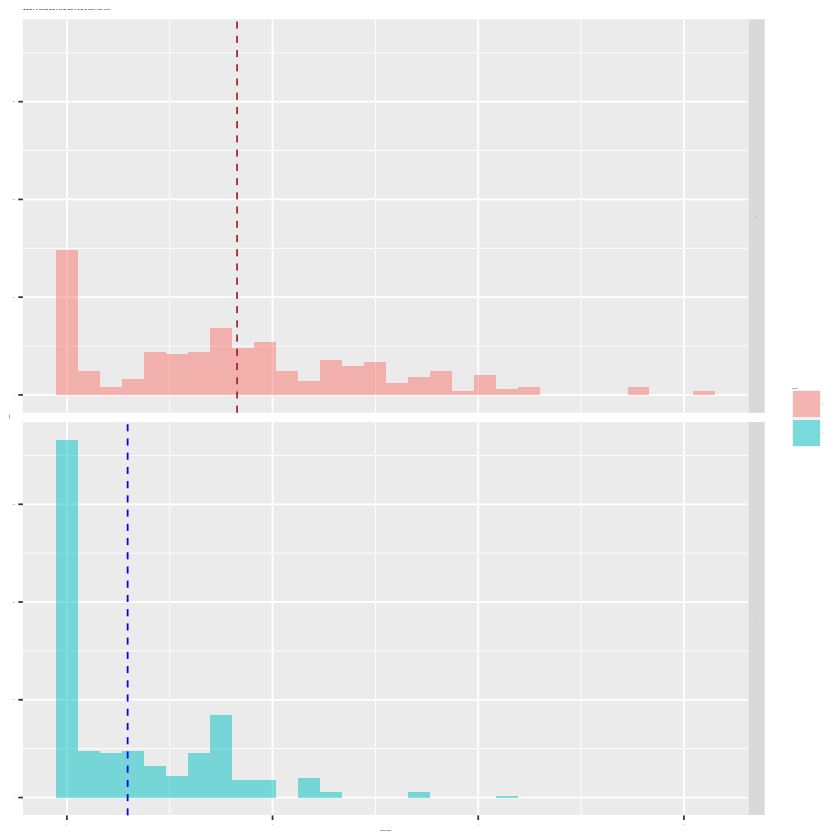

In [14]:
oldpeak_plot <- ggplot(heart_train, aes(x = oldpeak, fill = target)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    geom_vline(data = filter(heart_train, target == 0), aes(xintercept = mean(filter(heart_train,  target == 0)$oldpeak)),
             color = "brown", linetype = "dashed") +
    geom_vline(data = filter(heart_train, target == 1), aes(xintercept = mean(filter(heart_train,  target == 1)$oldpeak)),
             color = "blue", linetype = "dashed") +
    facet_grid(rows = vars(target)) +
    labs(x = "ST Depression", fill = "Target") +
    ggtitle("Distribution of ST depression induced by exercise relative to resting and chance of heart attack") +
    theme(text = element_text(size = 1))
oldpeak_plot

## Summary table

In [15]:
summary_table <- heart_train |>
    group_by(target) |>
    summarize(mean_age = mean(age, na.rm = TRUE),
              mean_trestbps = mean(trestbps,na.rm = TRUE),
              mean_chol = mean(chol,na.rm = TRUE),
              mean_thalach = mean(thalach,na.rm = TRUE),
              mean_oldpeak = mean(oldpeak,na.rm = TRUE),
              count = n())
summary_table

target,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak,count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,56.53388,134.6640,253.2439,139.2005,1.6550136,369
1,52.49869,129.4016,243.4882,159.3570,0.5908136,381


In [16]:
missing_table <- data.frame(Column_Names = colnames(heart_data), 
                            Missing_Values = colSums(is.na(heart_data)))
missing_table

,Column_Names,Missing_Values
,<chr>,<dbl>
age,age,0
sex,sex,0
cp,cp,0
trestbps,trestbps,0
chol,chol,0
fbs,fbs,0
restecg,restecg,0
thalach,thalach,0
exang,exang,0


We dont have any null or missing values in the dataset

## Methods and Results

* We will classify `target` variable using the KNN model. Using `age`, `trestbps`, `chol`, `thalach` and `oldpeak` as predictors in our classification.
* All of these variables we chose are quantitative data. Looking at the preliminary visualizations, it appears that there are clear differences and similiarities in some attributes of the two categories of `target`. Since the 5 predictors we chose seem to have a good distribution with the target variable, we decided they are useful predictors and chose them.
* We first read the data using read_csv and clean the data by removing  those rows which consisted of certain inaccurate values for thal and ca variables. These rows consisted of values which lied outside the range of values possible for these two variables.
* Then we only select the above mentioned 5 columns as others are not viable and not needed for our classification model.
* Our clean and wrangled data is then split into testing and training sets.
* Using the training data we create a recipe for predicting our target variable with the 5 predictor variables. We also center and scale all the predictors and standardize them as a part of the recipe.
* Then we perform a five fold cross validation
* We use another function: vfold_cv. This function splits our training data into v (V = 5) folds automatically. We set the strata argument to the categorical label variable (here, target) to ensure that the training and validation subsets contain the right proportions of each category of observation.
* Since cross-validation helps us evaluate the accuracy of our classifier, we can use cross-validation to calculate an accuracy for each value of  K in a reasonable range, and then pick the value of K.That gives us the best accuracy. The tidymodels package collection provides a very simple syntax for tuning models: each parameter in the model to be tuned should be specified as tune() in the model specification rather than given a particular value.
* Then instead of using fit or fit_resamples, we will use the tune_grid function to fit the model for each value in a range of parameter values. Then , we create the k_vals data frame with the neighbors variable containing values from 1 to 14 (stepping by 1) using the seq function. Then we pass that data frame to the grid argument of tune_grid.
* We visualize the results is by using confusion matrix to get the accuracy or the classification and plot a K vs. accuracy plot.
* For k = 2 , we had the highest cross validation accuracy , so we use that as our ideal k value which can yield in highest accuracy for predicting out testing data
* Using a new knn specification with k = 2 and a workflow consisring of our recipe from the training data, we predict our testing values for the testing data and obtain the accuracy for the data which is 97.21%.
* Upon plotting a confusuion matrix, 120 values were corectly predicted for target value 0 and 3 were mispredicted as target value 1. 4 values were mispredicted as 0 and 124 values were correctly precdicted as 1.

## Expected outcomes and significance

**What do you expect to find?**
We expect to find whether an individual will have low or high chance of heart attack. 

**What impact could such findings have?**
These findings could be helpful in the medical sector in predicting heart attack instances in patients and take proper precaution/treatments to prevent it from happening.

**What future questions could this lead to?**
Many other questions can follow this one. Such as:
* What are the main risk factors associated with heart attacks?
* Are there any early warning signs that can indicate an impending heart attack?
* Can machine learning models be integrated into daily medical practice to improve early detection and prevention of heart attacks?
* What impact could integrating heart attack prediction models in the healthcare sector have on healthcare costs and patient health?